In [2]:
import pickle
import json
import numpy as np

# Function to load the data from the json file
def load_from_json(file_path):
    with open(file_path, "r") as file:
        data = json.load(file)
    return data

# Load these embeddings from the pickle files
train_embeddings_file = "Task1_Fasttext_train_embeddings.pkl"
val_embeddings_file = "Task1_Fasttext_val_embeddings.pkl"
test_embeddings_file = "Task1_Fasttext_test_embeddings.pkl"

train_embeddings_loaded = pickle.load(open(train_embeddings_file, "rb"))
val_embeddings_loaded = pickle.load(open(val_embeddings_file, "rb"))
test_embeddings_loaded = pickle.load(open(test_embeddings_file, "rb"))

# Load the labels from the json files
train_labels = {}
val_labels = {}
test_labels = {}

train_label_path = "C:/Users/amilb/Documents/GitHub/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_train_labels.json"
val_label_path = "C:/Users/amilb/Documents/GitHub/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_val_labels.json"
test_label_path = "C:/Users/amilb/Documents/GitHub/CSE556-NLP-Assignments/Assignment 2/Task1_Dataset_NER/NER_test_labels.json"

train_labels = load_from_json(train_label_path)
val_labels = load_from_json(val_label_path)
test_labels = load_from_json(test_label_path)

In [3]:
# discarding the sentences with length greater than 174
# for train

train_labels = {k: v for k, v in train_labels.items() if len(v) <= 174}
train_embeddings_loaded = {k: v for k, v in train_embeddings_loaded.items() if len(v) <= 174}

# for val
val_labels = {k: v for k, v in val_labels.items() if len(v) <= 174}
val_embeddings_loaded = {k: v for k, v in val_embeddings_loaded.items() if len(v) <= 174}

# for test
test_labels = {k: v for k, v in test_labels.items() if len(v) <= 174}
test_embeddings_loaded = {k: v for k, v in test_embeddings_loaded.items() if len(v) <= 174}

In [4]:
# For each key, pad the embeddings and labels to the maximum length of 174
# For padding labels, use 'O' tag
# For padding embeddings, use a vector of zeros
max_length = 174

for key in train_embeddings_loaded:
    label = train_labels[key]
    embeddings = train_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    train_labels[key] = label
    train_embeddings_loaded[key] = embeddings

In [5]:
for key in val_embeddings_loaded:
    label = val_labels[key]
    embeddings = val_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    val_labels[key] = label
    val_embeddings_loaded[key] = embeddings

for key in test_embeddings_loaded:
    label = test_labels[key]
    embeddings = test_embeddings_loaded[key]

    # Pad the labels
    if len(label) < max_length:
        label = label + ['O'] * (max_length - len(label))

    # Pad the embeddings
    if len(embeddings) < max_length:
        embeddings = np.concatenate((embeddings, np.zeros((max_length - len(embeddings), 300))), axis=0)

    test_labels[key] = label
    test_embeddings_loaded[key] = embeddings

In [6]:
#get all the unique labels
unique_labels = set()
for labels in train_labels.values():
    unique_labels.update(labels)

#giving all labels index
labels_to_index = {label: index for index, label in enumerate(unique_labels)}
print(labels_to_index)

{'B_STATUTE': 0, 'I_PRECEDENT': 1, 'I_CASE_NUMBER': 2, 'B_PROVISION': 3, 'B_DATE': 4, 'I_GPE': 5, 'B_RESPONDENT': 6, 'B_COURT': 7, 'I_RESPONDENT': 8, 'B_GPE': 9, 'I_JUDGE': 10, 'B_OTHER_PERSON': 11, 'I_ORG': 12, 'I_STATUTE': 13, 'I_OTHER_PERSON': 14, 'I_COURT': 15, 'B_PRECEDENT': 16, 'I_PETITIONER': 17, 'B_PETITIONER': 18, 'I_PROVISION': 19, 'B_ORG': 20, 'B_CASE_NUMBER': 21, 'B_JUDGE': 22, 'B_WITNESS': 23, 'I_WITNESS': 24, 'I_DATE': 25, 'O': 26}


In [7]:
# Function to convert labels to indices
def labels_to_indices(labels, label_to_index):
    return [[label_to_index[label] for label in sentence_labels] for sentence_labels in labels]

# Convert the labels to indices
train_labels_indices = labels_to_indices(train_labels.values(), labels_to_index)
val_labels_indices = labels_to_indices(val_labels.values(), labels_to_index)
test_labels_indices = labels_to_indices(test_labels.values(), labels_to_index)

In [8]:
# checking the length of the labes and embeddings for first 5 keys
for key in list(train_labels.keys())[:5]:
    print(key, len(train_labels[key]), len(train_embeddings_loaded[key]))

b29019e16fc64e5da48f20706b152fae 174 174
b8f6ac625fb9435db21c94644bf7784f 174 174
4bbb0629e66146edaf4ac7bde47062fb 174 174
0373124f0bc54a38ba366718e5dd40eb 174 174
12934312395b4f2cbcf5011d0a9e949e 174 174


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

In [11]:
num_classes = len(labels_to_index)
# Model parameters
input_dim = 300  # Size of the word vectors
hidden_dim = 256  # RNN hidden state size
output_dim = num_classes  # Number of output classes
num_layers = 1  # Number of RNN layers

In [12]:
# Create the model
model = RNNModel(input_dim, hidden_dim, output_dim, num_layers)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset

# Convert the data to PyTorch tensors 
# embeddings to dtype float
# labels to dtype long
train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)
train_labels_tensor = torch.tensor(train_labels_indices, dtype=torch.long)

val_embeddings_tensor = torch.tensor([val_embeddings_loaded[key] for key in val_labels], dtype=torch.float)
val_labels_tensor = torch.tensor(val_labels_indices, dtype=torch.long)

test_embeddings_tensor = torch.tensor([test_embeddings_loaded[key] for key in test_labels], dtype=torch.float)
test_labels_tensor = torch.tensor(test_labels_indices, dtype=torch.long)
                                  
# Create the DataLoader
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)
test_dataset = TensorDataset(test_embeddings_tensor, test_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

C:\Users\amilb\AppData\Local\Temp\ipykernel_24428\1514317114.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  train_embeddings_tensor = torch.tensor([train_embeddings_loaded[key] for key in train_labels], dtype=torch.float)


In [13]:
# Tracking variables
training_losses = []
validation_losses = []
training_f1_scores = []
validation_f1_scores = []
def calculate_accuracy(true_labels, predicted_labels):
    correct = (true_labels == predicted_labels).sum()
    total = len(true_labels)
    accuracy = correct / total
    return accuracy

epochs = 10
for epoch in range(epochs):
    model.train()
    train_losses, val_losses = [], []
    train_preds, train_true = [], []
    val_preds, val_true = [], []

    # Training loop
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        _, predicted = torch.max(outputs.data, 2)
        train_preds.extend(predicted.view(-1).cpu().numpy())
        train_true.extend(labels.view(-1).cpu().numpy())

    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = loss_function(outputs.view(-1, num_classes), labels.view(-1))
            val_losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 2)
            val_preds.extend(predicted.view(-1).cpu().numpy())
            val_true.extend(labels.view(-1).cpu().numpy())

    # Calculate metrics
    train_f1 = f1_score(train_true, train_preds, average='macro')
    val_f1 = f1_score(val_true, val_preds, average='macro')
    train_accuracy = calculate_accuracy(np.array(train_true), np.array(train_preds))
    val_accuracy = calculate_accuracy(np.array(val_true), np.array(val_preds))

    # Store metrics
    training_losses.append(np.mean(train_losses))
    validation_losses.append(np.mean(val_losses))
    training_f1_scores.append(train_f1)
    validation_f1_scores.append(val_f1)

    print(f'Epoch {epoch+1}, Training Loss: {training_losses[-1]}, Validation Loss: {validation_losses[-1]}, '
          f'Training F1: {training_f1_scores[-1]}, Validation F1: {validation_f1_scores[-1]}, '
          f'Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1, Training Loss: 0.2750358043379518, Validation Loss: 0.1518097468548351, Training F1: 0.036905200167046764, Validation F1: 0.03650394678210444, Training Accuracy: 0.9649, Validation Accuracy: 0.9677
Epoch 2, Training Loss: 0.14156922128096044, Validation Loss: 0.11461515343851514, Training F1: 0.05316023504793681, Validation F1: 0.06598137302419958, Training Accuracy: 0.9700, Validation Accuracy: 0.9720
Epoch 3, Training Loss: 0.12087472796855694, Validation Loss: 0.115364887068669, Training F1: 0.09984923878641509, Validation F1: 0.10023330003258081, Training Accuracy: 0.9724, Validation Accuracy: 0.9712
Epoch 4, Training Loss: 0.09233910164450744, Validation Loss: 0.07753916573193338, Training F1: 0.18392537221464222, Validation F1: 0.2639924321211169, Training Accuracy: 0.9751, Validation Accuracy: 0.9786
Epoch 5, Training Loss: 0.08214074904581466, Validation Loss: 0.06804112924469842, Training F1: 0.2931870160248096, Validation F1: 0.3645798917020339, Training Accuracy: 0.

In [14]:
from sklearn.metrics import f1_score, accuracy_score

# Initialize lists to store predictions and actual values
test_preds, test_true = [], []

# Switch model to evaluation mode
model.eval()

with torch.no_grad():  # Do not compute gradients
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 2)  # Get the predicted classes
        
        test_preds.extend(predicted.view(-1).numpy())  # Flatten and store predictions
        test_true.extend(labels.view(-1).numpy())  # Flatten and store true labels

# Calculate the F1 score for the test set
test_f1 = f1_score(test_true, test_preds, average='macro')

# Calculate accuracy for the test set
test_accuracy = accuracy_score(test_true, test_preds)

# Print the F1 score and accuracy
print(f'Test F1 Score: {test_f1}')
print(f'Test Accuracy: {test_accuracy}')

Test F1 Score: 0.45588716947804175
Test Accuracy: 0.9844882205148746


Text(0, 0.5, 'Loss')

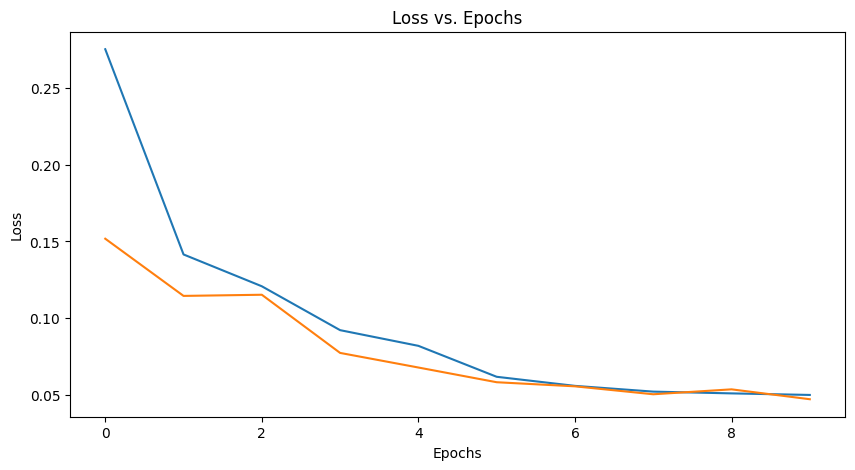

In [15]:
import matplotlib.pyplot as plt

# Loss plot
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')